In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from math import sqrt, pi, exp, log2
from random import random
from hilbertcurve.hilbertcurve import HilbertCurve
import sys
import itertools

np.seterr(all="raise")


def norm_pdf(Y, mu, sig):
    return np.exp((-(Y - mu) ** 2) / (2 * sig ** 2)) / (sqrt(2 * pi) * sig)


def multi_norm_pdf(Y, mu, sig):
    return np.exp(-0.5 * (Y - mu).T @ np.linalg.inv(sig) @ (Y - mu)) / (
        (2 * pi) ** mu.shape[0] * sqrt(abs(np.linalg.det(sig)))
    )

In [31]:
class Chain:
    """ This class implement the conversion of an image into a chain

    This class contains some utilities to manipulate markov chains in an image context.

    Attributes:
    -----------
                values : numpy.array
                    The numpy array containing the values of the chain
                t : int
                    The lenght of the chain
                categories : numpy.array
                    The different categories we found in our chain
                nb_catergories : int
                    The number of categories in our chain
                index_categories: dict
                    An index to transform categories into int
    Methods:
    --------
                get_category()
                    Return the categories of the chain and set the class
                    attributes categories with the computed values.
                get_category_info()
                    Compute and set nb_categories and index_categories
                init_from_image(image,categories=np.array([]))
                    Get an image and transform it to a chain using hilbert peano path. If categories are given 
                    set this categories as an atribute
                get_image()
                    Output a 2d numpy array containing the image represented in the chain using the inverse hilbert peano path
                plot_image(title=None,show=True)
                    This function plot the image represented in the chain and if given a title. show the plot if the attribute is setted to true
                error_rate(B)
                    Computes the error rate between 2 differents chains
                gaussian_noise(mean,std)
                    Output a noisy version of the original chain using some gaussian assumption
                gaussian_noise_couple(mean,std):
                    Output a noisy version of the original chain using some 2d-gaussian assumption
                x_transition_true()
                    Returns the transition matrix of the chain (with a stationnary assumption)
                x_joint_true()
                    Returs the joint distribution matrix of the chain (with a stationnary assumption)

    """

    def __init__(self, chain=np.array([]), categories=np.array([])):

        self.values = chain
        self.t = self.values.shape[0]
        self.categories = categories
        self.nb_categories = categories.shape[0]
        self.index_categories = dict()
        for i in range(self.nb_categories):
            self.index_categories[self.categories[i]] = i

    # Utilities

    def get_category(self):
        """ Compute the categories of the chain and set the class
            attributes categories with the computed values.

            Returns: 
            --------
            numpy.array
                A numpy array which contain the categories of the chain


        """

        categories = np.unique(self.values)
        self.categories = categories
        return categories

    def get_category_info(self):
        """Compute and set nb_categories and index_categories"""

        self.index_categories = dict()
        self.nb_categories = self.categories.shape[0]
        for i in range(self.nb_categories):
            self.index_categories[self.categories[i]] = i

    def init_from_image(self, image, categories=np.array([])):
        """ Get an image and transform it to a chain using hilbert peano path. If categories are given 
            set this categories as an atribute

            Parameters
            ----------
                image: 2d arraylike (for example PIL.Image)
                    The image we want to convert to a chain
                categories: numpy.array (optional)
                    If set, overwrite the computed categories
        """

        mat = np.asarray(image)
        n = len(mat)
        chaine = np.zeros(n * n, dtype="int64")
        hilbert_curve = HilbertCurve(int(log2(n)), 2)
        for i in range(n):
            for j in range(n):
                chaine[hilbert_curve.distance_from_coordinates(
                    [i, j])] = mat[i][j]
        self.values = chaine
        self.t = chaine.shape[0]
        if categories.size > 0:
            self.categories = categories
        else:
            self.get_category()
        self.get_category_info()
        

    def get_image(self):
        """ Output a 2d numpy array containing the image represented in the chain using the inverse hilbert peano path

        Returns
        -------
            numpy.array
                An 2d matrix containing the values of the image

        """

        m = int(sqrt(self.t))
        mat = np.zeros((m, m))
        hilbert_curve = HilbertCurve(int(log2(self.t)), 2)
        for i in range(self.t):
            coor = hilbert_curve.coordinates_from_distance(i)
            mat[coor[0]][coor[1]] = self.values[i]
        return mat

    def plot_image(self, title=None, show=True):
        """ This function plot the image represented in the chain and if given a title. show the plot if the attribute is setted to true

            Parameters
            ----------
                title: str (optional)
                    If sed add a title to the image plot. (default is None)
                show: str (optional)
                    If true show the plot. (default is True)
        """
        plt.title(title)
        plt.imshow(self.get_image(), cmap="Greys_r")
        if show:
            plt.show()

    def error_rate(self, B):
        """ Computes the error rate between 2 differents chains

            Parameters
            ----------
                B: Chain
                    The other chain we want to compute the error with

            Returns
            -------
                float
                    The error rate between the 2 chains
        """
        err = np.sum((self.values != B.values))/self.t
#         mean = np.mean(np.abs(self.values - B.values) / 255)
#         return min(mean, 1 - mean)
        return min(err, 1 - err)

    # Different noises

    def gaussian_noise(self, mean, std):
        """ Output a noisy version of the original chain using some gaussian assumption

            Parameters
            ----------
                mean: numpy.array of shape (self.nb_categories,1)
                    Contains the gaussian means we want to noise our image with.
                std: numpy.array of shape (self.nb_categories,1)
                    Contains the gaussian standard deviation we want to noise our image with.

            Returns
            -------
                HMC
                    Return a hidden markov chain with our noisy chain
        """
        gauss = []
        for i in range(self.nb_categories):
            gauss += [np.random.normal(mean[i], std[i], self.t)]
        bruit = np.zeros((self.nb_categories, self.t))
        for i in range(self.nb_categories):
            bruit[i] = np.where(self.values == self.categories[i], gauss[i], 0)
        return HMC(bruit.sum(axis=0), self.categories)

    def gaussian_noise_couple(self, mean, std):
        """ Output a noisy version of the original chain using some 2d-gaussian assumption

            Parameters
            ----------
                mean: numpy.array of shape (self.nb_categories,self.nb_categories,2)
                    Contains the gaussian means we want to noise our image with.
                std: numpy.array of shape ((self.nb_categories,self.nb_categories,4)
                    Contains the gaussian covariance matrix we want to noise our image with.

            Returns
            -------
                PMC
                    Return a pairwise markov chain with our noisy chain

        """

        chaine_bruite = np.zeros(self.t)
        chaine_bruite[0] = np.random.normal(
            mean[self.index_categories[self.values[0]]][
                self.index_categories[self.values[1]]
            ][0],
            std[self.index_categories[self.values[0]]][
                self.index_categories[self.values[1]]
            ][0][0],
        )
        for i in range(1, self.t):
            mean_i = mean[self.index_categories[self.values[i - 1]]][
                self.index_categories[self.values[i]]
            ]
            std_i = std[self.index_categories[self.values[i - 1]]][
                self.index_categories[self.values[i]]
            ]
            chaine_bruite[i] = np.random.normal(
                mean_i[1]
                + std_i[1][0] / std_i[0][0] *
                (chaine_bruite[i - 1] - mean_i[0]),
                sqrt(std_i[1][1] - std_i[0][1] * std_i[1][0] / std_i[0][0]),
            )
        return PMC(chaine_bruite, self.categories)

    # Compute probas
    def generate_mc(self,categories,p0,transition,t):
        x0=np.random.choice(categories,p=p0)
        chain=[x0]
        for _ in range(t-1):
            x1=np.random.choice(categories,p=transition[categories.tolist().index(x0),])
            chain+=[x1]
            x0=x1
        return Chain(chain=np.array(chain),categories=categories)

    def x_transtion_true(self):
        """ Returns the transition matrix of the chain (with a stationnary assumption)

            Returns
            -------
                numpy.array
                    Matrix containing the transition matrix of our chain
        """
        X = self.values
        transitions = np.zeros((self.nb_categories, self.nb_categories))
        x_list = X.tolist()
        for (i, j) in zip(x_list, x_list[1:]):
            transitions[self.index_categories[int(i)]][
                self.index_categories[int(j)]
            ] += 1
        transitions = (transitions.T / transitions.sum(axis=1)).T
        return transitions

    def x_joint_true(self):
        """ Returns the joint distribution matrix of the chain (with a stationnary assumption)

            Returns
            -------
                numpy.array
                    Matrix containing the joint distribution matrix of our chain

        """
        X = self.values
        transitions = np.zeros((self.nb_categories, self.nb_categories))
        x_list = X.tolist()
        for (i, j) in zip(x_list, x_list[1:]):
            transitions[self.index_categories[int(i)]][
                self.index_categories[int(j)]
            ] += 1
        return transitions/(transitions.sum())

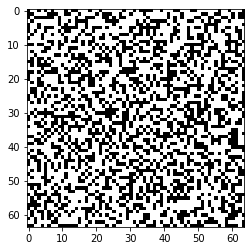

In [19]:
chain=Chain()
categories=np.array([1,2])
p0=np.array([0.7,0.3])
transition=np.array([[0.3,0.7],[0.5,0.5]])
chain=chain.generate_mc(categories,p0,transition,64*64)
chain.plot_image()

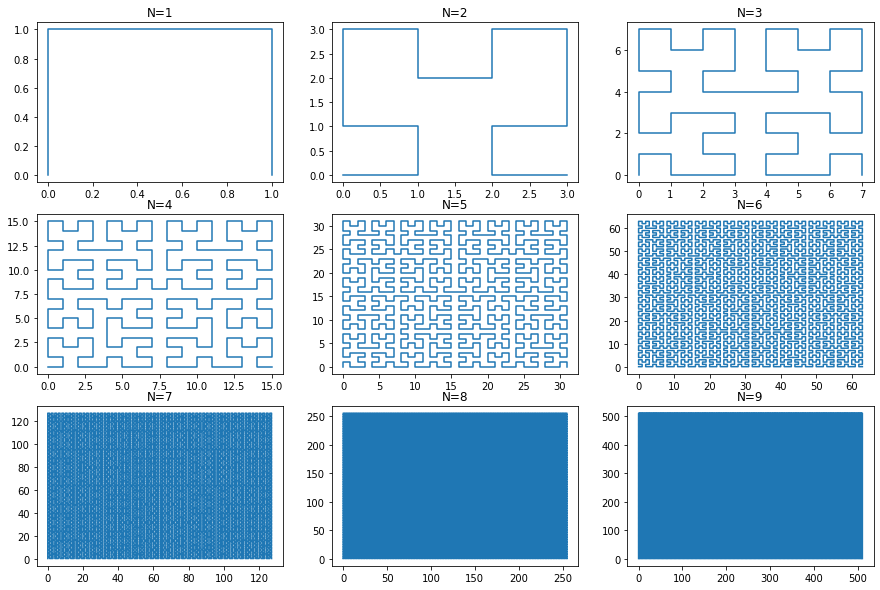

In [3]:
fig = plt.figure(figsize=(15, 10))
for i in range(1, 10):
    fig.add_subplot(3, 3, i)
    N = 2 ** (i)
    hilbert_curve = HilbertCurve(int(log2(N)), 2)
    coords = np.zeros((N ** 2, 2))
    for j in range(N ** 2):
        coords[j] = hilbert_curve.coordinates_from_distance(j)
    plt.title("N=" + str(i))
    plt.plot(coords[:, 0], coords[:, 1])

In [42]:
class HMC(Chain):
    """ This class implements inference for hidden markov chains and parameters estimation
    
    Methods:
    -------
        gaussian_assumption(mean,std)
            Compute the probabilities of the chain given some gaussian assumption
        forward(gaussian,t,transition,p)
            Compute the forward probabilities of our HMC
        backward(gaussian,t,transition)
            Compute the backward probabilities of our HMC
        baum_welch(p0, transitions0, mean0, std0, nb_iter)
            Estimation of the model parameters using the baum welch algorithm
        MPM(transitions, p, mean, std,estimate_param=True,nb_iter_bw=10)
            Estimation of the hidden chainof our model using MPM
            
    
    """
    def __init__(self, chain=np.array([]), categories=np.array([])):

        super().__init__(chain, categories)

    def gaussian_assumption(self, mean, std):
        """  Compute the likelihood function of the chain given some gaussian likelihood assumption
        
        Parameters
            ----------
                mean: numpy.array of shape (self.nb_categories,1)
                    Contains the gaussian means we want to compute our probabilities with.
                std: numpy.array of shape (self.nb_categories,1)
                    Contains the gaussian standart deviation we want to compute our probabilities with.
            Returns
            -------
                numpy.array
                    Array containing each possible gaussian probability for each category
        
        """
        gaussians = np.zeros((self.nb_categories, self.t))
        for i in range(self.nb_categories):
            gaussians[i] = norm_pdf(self.values, mean[i], std[i])
        return gaussians

    def forward(self, gaussians, t, transitions, p):
        """ Compute the forward probabilities of our HMC
        
            Parameters:
            -----------
                gaussian: numpy.array
                    Contains the gaussian likelihood function of our model
                t: int
                    the length for which we want to compute our forward probability
                transitions: numpy.array
                    The transition matrix of our original chain
                p: numpy.array
                    The priori probability array
            
            Returns:
                numpy.array
                    An array containing the forward probabilities
        """

        alpha = np.zeros((self.nb_categories, t))
        alpha[:, 0] = p * gaussians[:, 0]
        alpha[:, 0] = alpha[:, 0] / (alpha[:, 0].sum())
        for i in range(1, t):
            alpha[:, i] = gaussians[:,i]*(alpha[:,i-1]@transitions)
            alpha[:, i] = alpha[:, i] / (alpha[:, i].sum())
        return alpha

    def backward(self, gaussians, t, transitions):
        """ Compute the backward probabilities of our HMC
        
            Parameters:
            -----------
                gaussian: numpy.array
                    Contains the gaussian likelihood function of our model
                t: int
                    the length for which we want to compute our forward probability
                transitions: numpy.array
                    The transition matrix of our original chain

            Returns:
                numpy.array
                    An array containing the backward probabilities
        """

        beta = np.zeros((self.nb_categories, t))
        beta[:, t-1] = np.ones(self.nb_categories)
        beta[:, t-1] = beta[:, t-1] / (beta[:, t-1].sum())
        for i in reversed(range(t-1)):
            beta[:, i] = (gaussians[:, i+1] * beta[:, i + 1]) @ np.transpose(transitions)
            beta[:, i] = beta[:, i] / (beta[:, i].sum())
        return beta

    def baum_welch(self, p0, transitions0, mean0, std0, nb_iter):
        """ Estimation of the model parameters using the baum welch algorithm
        
            Parameters
            ----------
                p0: numpy.array
                    Initial estimation of the priori probabilities
                transitions0: np.array
                    Intial estimation of the transition matrix
                mean0: np.array
                    Initial estimation of the gaussian likelihood function mean
                sd0: np.array
                    Initial estimation of the gaussian likelihood function standard deviation
                nb_iter: int
                    Number of iterations of the algorithme
            
            Returns
            -------
            np.array
                Array with the priori estimation
            np.array
                array with the transition matric estimation
            np.array
                array with the gaussian likelihood function mean estimation
            np.array
                array with the gaussian likelihood function standard deviation estimation
        
        """

        p, transitions, mean, std = p0, transitions0, mean0, std0
        t = self.t
        Y = self.values
#         print({'iter':0, 'p':p, 'transitions':transitions, 'mean':mean, 'std':std})
        for i in range(nb_iter):

            gaussians = self.gaussian_assumption(mean, std)
            alpha = self.forward(gaussians, t, transitions, p)
            beta = self.backward(gaussians, t, transitions)

            gamma = (
                alpha[:, np.newaxis, :-1]
                * (gaussians[np.newaxis, :, 1:]
                * beta[np.newaxis, :, 1:]
                * transitions[:, :, np.newaxis])
            )
            gamma = gamma / (gamma.sum(axis=(0,1)))
            psi = alpha * beta
            psi = psi / (psi.sum(axis=0))

            transitions = np.transpose(np.transpose((gamma.sum(axis=2))) / (psi[:,:-1].sum(axis=1)))
            mean = ((psi * Y[np.newaxis, :]).sum(axis=1)) / (psi.sum(axis=1))
            std = np.sqrt(
                ((psi * (Y[np.newaxis, :] - mean[:, np.newaxis]) ** 2).sum(axis=1))
                / (psi.sum(axis=1))
            )
            p = (psi.sum(axis=1))/psi.shape[1]
            
#             print({'iter':i+1, 'p':p, 'transitions':transitions, 'mean':mean, 'std':std})

        return (p, transitions, mean, std)

    def MPM(self, transitions, p, mean, std,estimate_param=True,nb_iter_bw=10):
        """ Estimation of the hidden chainof our model using MPM
        
            Parameters
            ----------
                p: numpy.array
                    Estimation of the priori probabilities
                transitions: np.array
                    Estimation of the transition matrix
                mean: np.array
                    Estimation of the gaussian likelihood function mean
                std: np.array
                    Estimation of the gaussian likelihood function standard deviation
                estimate_param: boolean (optional)
                    If we need to estimate the parameters or not. Default = True
                nb_iter: int
                    Number of iterations of the algorithme
            Return
            ------
                Chain
                    Return a Chain with the infered chain
        """
        # Parameter Estimation
        if(estimate_param):
            p, transitions, mean, std = self.baum_welch(
                p, transitions, mean, std, nb_iter_bw
            )
        # Prediction
        gaussians = self.gaussian_assumption(mean, std)
        alpha = self.forward(gaussians, self.t, transitions, p)
        beta = self.backward(gaussians, self.t, transitions)
        p = alpha * beta
        categories_pmax = np.argmax(p, axis=0)

        return Chain(self.categories[categories_pmax], self.categories)

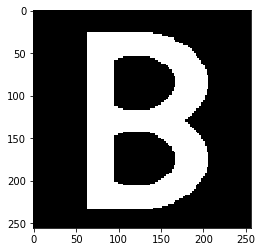

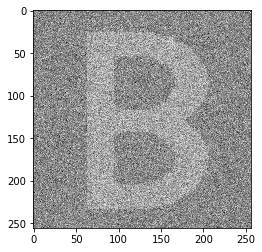

[[0.99214462 0.00785538]
 [0.01914001 0.98085999]]


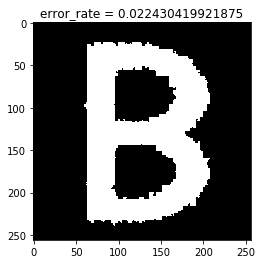

In [23]:
image_chain = Chain()
image_chain.init_from_image(np.array(Image.open("./images/beee2.bmp")))
image_chain.plot_image()
mean = np.array([1, 2])
std = np.array([1, 1])
p = np.array([0.5, 0.5])
image_bruite = image_chain.gaussian_noise(mean, std)
image_bruite.plot_image()
transitions = image_chain.x_transtion_true()
print(transitions)
mean0 = np.array([0.5, 4])
std0 = np.array([2, 0.5])
p0 = np.array([0.5, 0.5])
image_segmente = image_bruite.MPM(transitions, p0, mean, std)
image_segmente.plot_image(
    title="error_rate = " + str(image_chain.error_rate(image_segmente))
)

In [76]:
class PMC(Chain):
    """ This class implements inference for pairwise hidden markov chains and parameters estimation
    
    Methods:
    -------
        compute_probas_chaine(self, mean, cov, x_joint)
            Compute the probabilities of the chain given some coupled gaussian assumption 
        forward(gaussian,t,transition,p)
            Compute the forward probabilities of our HMC
        backward(gaussian,t,transition)
            Compute the backward probabilities of our HMC
        baum_welch(p0, transitions0, mean0, cov0, nb_iter)
            Estimation of the model parameters using the baum welch algorithm
        MPM(transitions, p, mean, cov,estimate_param=True,nb_iter_bw=10)
            Estimation of the hidden chainof our model using MPM
        
    
    """
    def __init__(self, chain=np.array([]), categories=np.array([])):

        super().__init__(chain, categories)

    def compute_probas_chaine(self, mean, cov, x_joint):
        """Compute the probabilities of the chain given some coupled gaussian assumption 
        
            Parameters
            ----------
                mean: numpy.array
                    Mean vectors of our gaussian likelihood function. Shape = (self.nb_categories, self.nb_categories,2)
                cov: numpy.array
                    Covariance matrices of our gaussian likelihood function. Shape = (self.nb_categories, self.nb_categories,4)
                x_joint: numpy.array
                    Transition matrix of the hidden chain. Shape= (self.nb_categories, self.nb_categories)
            
            Returns
            -------
                numpy.array
                    Probability for the first element of the pairwise markov chain
                numpy.array
                    Transition probabilities for the rest of the pairwise markov chain
        """

        p_z_1 = np.zeros((self.nb_categories, self.nb_categories))

        categories_combi = list(
            itertools.chain.from_iterable(
                [
                    list(zip(self.categories.tolist(), x))
                    for x in itertools.permutations(self.categories.tolist())
                ]
            )
        )
        for i, j in categories_combi:
            p_z_1[self.index_categories[i]][self.index_categories[j]] = norm_pdf(
                self.values[0],
                mean[self.index_categories[i]][self.index_categories[j]][0],
                cov[self.index_categories[i]][self.index_categories[j]][0][0],
            )
        p_z_1 = (p_z_1 * x_joint).sum(axis=1)

        transi = np.zeros((self.nb_categories, self.nb_categories, self.t - 1))

        for k in range(0, self.t - 1):
            marginale = np.zeros((self.nb_categories, self.nb_categories))
            for i, j in categories_combi:
                marginale[self.index_categories[i]][
                    self.index_categories[j]
                ] = norm_pdf(
                    self.values[k],
                    mean[self.index_categories[i]][self.index_categories[j]][0],
                    cov[self.index_categories[i]][self.index_categories[j]][0][0],
                )
                transi[self.index_categories[i]][self.index_categories[j]][
                    k
                ] = multi_norm_pdf(
                    self.values[k : k + 2],
                    mean[self.index_categories[i]][self.index_categories[j]],
                    cov[self.index_categories[i]][self.index_categories[j]],
                )
            marginale = (marginale * x_joint).sum(axis=1)
            transi[:, :, k] = (transi[:, :, k] * x_joint) / marginale

        return (p_z_1, transi)

    def forward(self, t, transitions, p_z_1):
        """ Compute the forward probabilities of our PMC
        
            Parameters:
            -----------
                t: int
                    The length for which we want to compute our forward probability
                transitions: numpy.array
                    The transition matrix of our coupled chain for each step
                p_z_1: numpy.array
                    The probability array of the first element of the chain
            
            Returns:
                numpy.array
                    An array containing the forward probabilities
        """
        alpha = np.zeros((self.nb_categories, t))
        alpha[:, 0] = p_z_1
        alpha[:, 0] = alpha[:, 0] / (alpha[:, 0].sum())
        for i in range(1, t):
            alpha[:, i] = alpha[:, i - 1] @ transitions[:, :, i - 1]
            alpha[:, i] = alpha[:, i] / (alpha[:, i].sum())
        return alpha

    def backward(self, t, ntransitions):
        """ Compute the backward probabilities of our PMC
        
            Parameters:
            -----------
                t: int
                    The length for which we want to compute our forward probability
                transitions: numpy.array
                    The transition matrix of our coupled chain for each step
                p_z_1: numpy.array
                    The probability array of the first element of the chain
            
            Returns:
                numpy.array
                    An array containing the forward probabilities
        """
        beta = np.zeros((self.nb_categories, t))
        beta[:, t-1] = np.ones(self.nb_categories)
        beta[:, t-1] = beta[:, t-1] / (beta[:, t-1].sum())
        for i in reversed(range(t-1)):
            beta[:, i] = (beta[:, i + 1]) @ np.transpose(transitions[:, :, i])
            beta[:, i] = beta[:, i] / (beta[:, i].sum())
        return beta
    def generate_cond(self,x_joint,mean,cov):
        x0=np.random.choice(self.categories,p=x_joint.sum(axis=1))
        X=[x0]
        for y_n in range(1,self.t):
            p_x_1_y = np.zeros(self.nb_categories)

            for w in self.categories.tolist():
                p_x_1_y[self.index_categories[w]] = norm_pdf(
                    self.values[y_n],
                    mean[self.index_categories[x0]][self.index_categories[w]][0],
                    cov[self.index_categories[x0]][self.index_categories[w]][0][0],
                )
            p_x_1_y = (p_x_1_y * x_joint[self.index_categories[x0],])
            p_x_1_y=p_x_1_y/p_x_1_y.sum()
            x0=np.random.choice(self.categories,p=p_x_1_y)
            X+=[x0]
        return(Chain(chain=np.array(X),categories=self.categories))


    def ICE(self, x_joint_0, mean_0, cov_0, nb_iter,nb_sampling):
        """ Estimation of the model parameters using the baum welch algorithm
        
            Parameters
            ----------
                x_joint_0: numpy.array
                    Initial estimation of the hidden joint distribution
                mean0: np.array
                    Initial estimation of the gaussian likelihood function mean
                cov_0: np.array
                    Initial estimation of the gaussian likelihood function covariance matrix
                nb_iter: int
                    Number of iterations of the algorithme
                nb_sampling: int
                    Number of sampling for parameter estimation each step
            
            Returns
            -------
            np.array
                Array with the hidden joint distribution estimation
            np.array
                array with the gaussian likelihood function mean estimation
            np.array
                array with the gaussian likelihood function standard deviation estimation
        
        """

        x_joint, mean, cov=x_joint_0, mean_0, cov_0
        t = self.t
        Y_double = np.array([self.values[:-1],self.values[1:]])
                            
        for iter in range(nb_iter):
                        
            print('iter n '+str(iter))             
            x_joint_array=np.zeros((nb_sampling,self.nb_categories,self.nb_categories))
            mean_array=np.zeros((nb_sampling,self.nb_categories,self.nb_categories,2))
            cov_array=np.zeros((nb_sampling,self.nb_categories,self.nb_categories,2,2))
            for s in range(nb_sampling):
                generated_chain=self.generate_cond(x_joint,mean,cov)
                x_joint_array[s,]=generated_chain.x_joint_true()
                categories_combi = list(
                    itertools.chain.from_iterable(
                        [
                            list(zip(self.categories.tolist(), x))
                            for x in itertools.permutations(self.categories.tolist())
                        ]
                    )
                )
                for i, j in categories_combi:
                    x_bool_couple=np.where(generated_chain.values[:-1]==i,1,0)*np.where(generated_chain.values[1:]==j,1,0)
                    x_bool_couple_double=np.array([x_bool_couple,x_bool_couple])
                    mean_array[s,self.index_categories[i],self.index_categories[j],]=((x_bool_couple_double*Y_double).sum(axis=1))/(x_bool_couple.sum())
                    Y_double_center=Y_double-mean[s,self.index_categories[i],self.index_categories[j],]
                    cov_array[s,self.index_categories[i],self.index_categories[j],]=((Y_double_center*x_bool_couple_double).dot((Y_double_center*x_bool_couple_double).T))/(x_bool_couple.sum())
            x_joint=x_joint_array.mean(axis=0)
            mean=mean_array.mean(axis=0)
            cov=cov_array.mean(axis=0)

                

        return (x_joint,mean,cov)

    
    def MPM(self, x_joint_0,mean_0,cov_0,estimate_param=True,nb_iter=10,nb_sampling=1):
        """ Estimation of the hidden model
        
            Parameters
            ----------
                
                x_joint_0: np.array
                Array with the hidden joint distribution estimation
                mean_0: np.array
                array with the gaussian likelihood function mean estimation
                cov_0: np.array
                array with the gaussian likelihood function standard deviation estimation
                nb_iter: int (optional)
                    Number of iterations of the algorithme (default=10)
                nb_sampling: int (optional)
                    Number of samples for the estimtion (default=2)
                    
            Return
            ------
                Chain
                    Return a Chain with the infered chain
        """
        # Parameter Estimation
        
        if(estimate_param):
            x_joint, mean, cov = self.ICE(
                x_joint_0, mean_0, cov_0, nb_iter,nb_sampling
            )
        else:
            x_joint, mean, cov=x_joint_0, mean_0, cov_0
        p_z_1,transitions = self.compute_probas_chaine(mean, cov, x_joint)
        # Prediction
        alpha = self.forward(self.t, transitions, p_z_1)
        beta = self.backward(self.t, transitions)
        p = alpha * beta
        categories_pmax = np.argmax(p, axis=0)

        return Chain(self.categories[categories_pmax], self.categories)
 

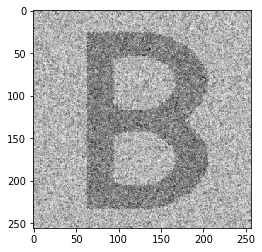

iter n 0
iter n 1
iter n 2
iter n 3
iter n 4
iter n 5
iter n 6
iter n 7
iter n 8
iter n 9


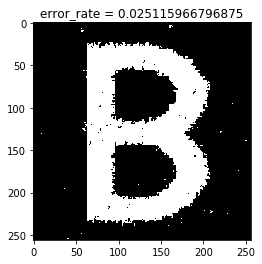

In [77]:
image_chain = Chain()
image_chain.init_from_image(np.array(Image.open("./images/beee2.bmp")))

# mean = np.array([[[-5, -5], [-3, 3]], [[3, -3], [5, 5]]])
# rho=0.4
# cov = np.array(
#     [
#         [[[14**2, rho*14*14], [rho*14*14, 14**2]], [[7**2, rho*(7*9)], [rho*(7*9), 9**2]]],
#         [[[9**2, rho*(7*9)], [rho*(7*9), 7**2]], [[20**2, rho*20*20], [rho*20*20, 20**2]]]
#     ]
# )

mean = np.array([[[3, 3], [2, 2]], [[4, 4], [1, 1]]])
cov = np.array(
    [
        [[[1, 0.5], [0.5, 1]], [[1, 0.5], [0.5, 1]]],
        [[[1, 0.5], [0.5, 1]], [[1, 0.5], [0.5, 1]]],
    ]
)
image_bruite = image_chain.gaussian_noise_couple(mean, cov)
image_bruite.plot_image()
x_joint = image_chain.x_joint_true()
# generate=image_bruite.generate_cond(x_joint,mean,cov)
# generate.plot_image()

image_segmente = image_bruite.MPM(x_joint,mean,cov,True)
image_segmente.plot_image(
    title="error_rate = " + str(image_chain.error_rate(image_segmente))
)

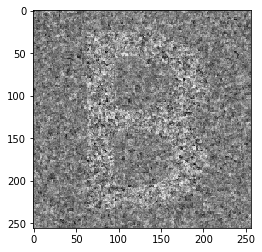

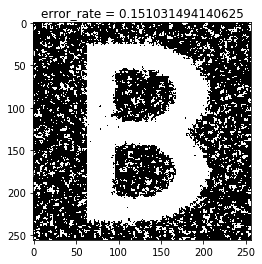

In [80]:
image_chain = Chain()
image_chain.init_from_image(np.array(Image.open("./images/beee2.bmp")))

mean = np.array([[[-5, -5], [-3, 3]], [[3, -3], [5, 5]]])
rho=0.2
cov = np.array(
    [
        [[[14**2, (1-rho)*14*14], [(1-rho)*14*14, 14**2]], [[7**2, rho*(7*9)], [rho*(7*9), 9**2]]],
        [[[9**2, rho*(7*9)], [rho*(7*9), 7**2]], [[20**2, (1-rho)*20*20], [(1-rho)*20*20, 20**2]]]
    ])

image_bruite = image_chain.gaussian_noise_couple(mean, cov)
image_bruite.plot_image()
x_joint = image_chain.x_joint_true()
image_segmente = image_bruite.MPM(x_joint,mean,cov, False)
image_segmente.plot_image(
    title="error_rate = " + str(image_chain.error_rate(image_segmente))
 
)